<a href="https://colab.research.google.com/github/kailen-mccauley/mnist-CNN-project/blob/master/KailenMcCauleyMINSTproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neptune



In [2]:
batchSize = 128
numEpochs = 10
dropout = 0.5
learningRate = 0.001
weightDecay = 0.003

In [3]:
# used to unzip the MNIST data files
import os
import gzip

# used to normalize the data and reshape it
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

# used to show the images
import matplotlib.pyplot as plt
import numpy as np

# used to perform our forwards and backwards passes
import torch.nn as nn
import torch.nn.functional as F

# optimizer
import torch.optim as optim

# connecting to Neptune Ai
import neptune
from neptune.utils import stringify_unsupported

In [4]:
run = neptune.init_run(project="kailen.mccauley/MNIST-Mini-Project",
                       api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiNzM4NWQ4Zi05NzY1LTQ2NjktYjRmYi1mNTUwM2QyMDRlMjYifQ==",
                       capture_stdout=True,
                       capture_stderr=True,
                       capture_traceback=True,
                       capture_hardware_metrics=True,
                       )

params = {
    "Batch Size": batchSize,
    "Epochs": numEpochs,
    "Dropout": dropout,
    "Optimizer": "Adam",
    "Learning Rate": learningRate,
    "Weight Decay": weightDecay,
    }
run["parameters"] = params

https://app.neptune.ai/kailen.mccauley/MNIST-Mini-Project/e/MNIS-60


In [5]:
# directory to the MNIST data set on Google drive
data_dir = '/content/drive/MyDrive/VIP /MNIST'


#loading in the images from their directory
def load_mnist_images(file_path):
    with open(file_path, 'rb') as file:
        data = np.frombuffer(file.read(), np.uint8, offset=16)
        data = data.reshape(-1, 28, 28)  # MNIST images are 28x28 pixels
        return data

#loading in the labels from their directory
def load_mnist_labels(file_path):
    with open(file_path, 'rb') as file:
        labels = np.frombuffer(file.read(), np.uint8, offset=8)
        return labels


#directories
train_data = load_mnist_images(os.path.join(data_dir, '/content/drive/MyDrive/VIP /MNIST/train-images.idx3-ubyte.gz'))
train_labels = load_mnist_labels(os.path.join(data_dir, '/content/drive/MyDrive/VIP /MNIST/train-labels.idx1-ubyte.gz'))
test_data = load_mnist_images(os.path.join(data_dir, '/content/drive/MyDrive/VIP /MNIST/t10k-images.idx3-ubyte.gz'))
test_labels = load_mnist_labels(os.path.join(data_dir, '/content/drive/MyDrive/VIP /MNIST/t10k-labels.idx1-ubyte.gz'))


if(torch.cuda.is_available()):
  device = torch.device("cuda")
  print("CUDA is working!")

CUDA is working!


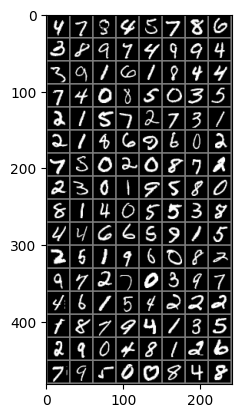

4     7     8     4     5     7     8     6     3     8     9     7     4     9     9     4     3     9     1     6     1     8     4     4     7     4     0     8     5     0     3     5     2     1     5     7     2     7     3     1     2     1     8     6     9     6     0     2     7     5     0     2     0     8     7     2     2     3     0     1     9     5     8     0     8     1     4     0     5     5     3     8     4     4     6     6     5     9     1     5     2     5     1     9     6     0     8     2     9     7     2     7     0     3     9     7     4     6     1     5     4     2     2     2     1     8     7     9     4     1     3     5     2     9     0     4     8     1     2     6     7     9     5     0     0     8     4     8    


In [6]:
#defining a transform
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])

# defining our custom data set for the MNIST
class CustomMNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index].copy()
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


batch_size = batchSize
# just our training set after it has been normalized
trainset = CustomMNISTDataset(train_data, train_labels, transform=transform)

# helps us so we can send it batches, rather than just single images during training
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# just our test set after it has been normalized
testset = CustomMNISTDataset(test_data, test_labels, transform=transform)

# helps us so we can send it batches, rather than just single images during testing

testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

#defining our classes
classes = ('0','1','2','3','4','5','6','7','8','9')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images from training images
imshow(torchvision.utils.make_grid(images))
# print labels corresponding to training images
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
#DEFINING OUR CONVOLUTIONAL NUERAL NETWORK

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#our actual network itself
net = Net().to(device)

# DEFINING A LOSS FUNCITON AND OPTIMIZER

#cross entropy loss
criterion = nn.CrossEntropyLoss()

# optimizer, here we are using stochastic gradient descent
optimizer = optim.Adam(net.parameters(), lr=learningRate, weight_decay=weightDecay)

In [9]:
for epoch in range(numEpochs):  # loop over the dataset multiple times

    # TRAINING OUR MODEL
    runningTrainLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # REPEATING TO CREATE 3 CHANNELS
        inputs = inputs.repeat(1,3,1,1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        trainLoss = criterion(outputs, labels)
        trainLoss.backward()
        optimizer.step()
        runningTrainLoss += trainLoss.item()
        outputs = outputs.detach()
        trainLoss = trainLoss.detach()
    run["Train/Epoch/Loss"].append(runningTrainLoss / len(trainset))
    correct = 0
    total = 0

    # VALIDATION TEST

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # since we're not training, we don't need to calculate the gradients for our outputs
    runningValidationLoss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            images = images.repeat(1, 3, 1, 1)
            outputs = net(images.to(device))


            # validation loss
            validationLoss = criterion(outputs, labels)
            runningValidationLoss += validationLoss.item()
            validationLoss = validationLoss.detach()
            run["Test/Validation Loss"].append(validationLoss / len(trainset))


            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            overallAccuracy = 100 * correct // total

            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    # Overall Accuracy
    print(f'Accuracy of the network on the 10000 test images: {overallAccuracy} %')
    run["Test/Overall Accuracy"].append(overallAccuracy)

    #Class Accruacy
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
        run["Test/Class "+classname+" Accuracy"].append(accuracy)


print('Finished Training')

# SAVING MODEL

ministPath = './MNIST_net.pth'
torch.save(net.state_dict(), ministPath)
run["Model/Saved Model"] = ministPath
run.stop()

Accuracy of the network on the 10000 test images: 97 %
Accuracy for class: 0     is 99.3 %
Accuracy for class: 1     is 99.8 %
Accuracy for class: 2     is 99.2 %
Accuracy for class: 3     is 98.7 %
Accuracy for class: 4     is 99.0 %
Accuracy for class: 5     is 97.0 %
Accuracy for class: 6     is 94.4 %
Accuracy for class: 7     is 98.6 %
Accuracy for class: 8     is 96.7 %
Accuracy for class: 9     is 93.7 %
Accuracy of the network on the 10000 test images: 98 %
Accuracy for class: 0     is 99.5 %
Accuracy for class: 1     is 99.5 %
Accuracy for class: 2     is 97.8 %
Accuracy for class: 3     is 98.3 %
Accuracy for class: 4     is 98.9 %
Accuracy for class: 5     is 98.8 %
Accuracy for class: 6     is 98.4 %
Accuracy for class: 7     is 98.3 %
Accuracy for class: 8     is 97.3 %
Accuracy for class: 9     is 95.7 %
Accuracy of the network on the 10000 test images: 98 %
Accuracy for class: 0     is 96.4 %
Accuracy for class: 1     is 99.1 %
Accuracy for class: 2     is 99.0 %
Accurac